# SAM 3-channel version: DWI, ADC and DifDif

In [1]:
#channels = "1C=DWI"
#channels = "3C=DWI_ADC_b0"
channels = "3C=DWI_ADC_DifDif"

In [2]:
# Loads all methods and data for testing on JAS
from methods_for_testing_SAM import *

/home/rosengaard/miniforge3/envs/medsam3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


General Sam model 3C=DWI_ADC_DifDif version
Volume: 1 of 8
Optimizing level 0 [max iter: 0]


  0%|          | 0/10 [00:00<?, ?it/s]/home/rosengaard/miniforge3/envs/medsam3.9/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 10/10 [01:52<00:00, 11.23s/it]

Dice for slice: 0.786


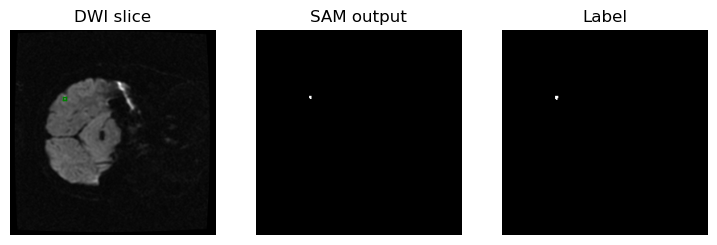

Dice for slice: 0.309


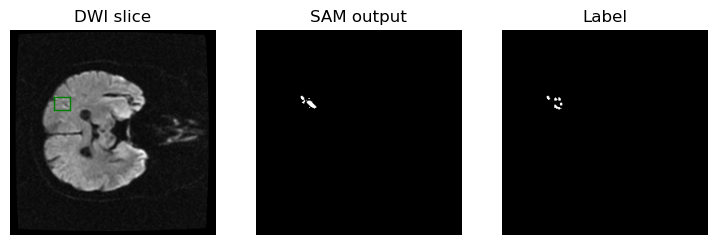

Dice for slice: 0.873


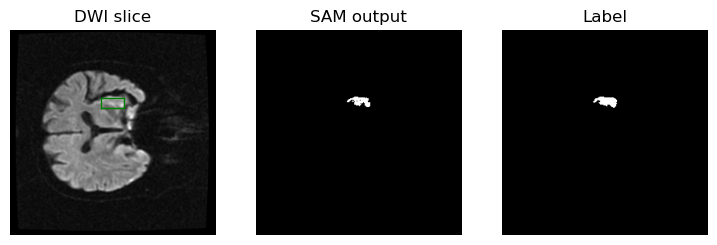

Dice for slice: 0.816


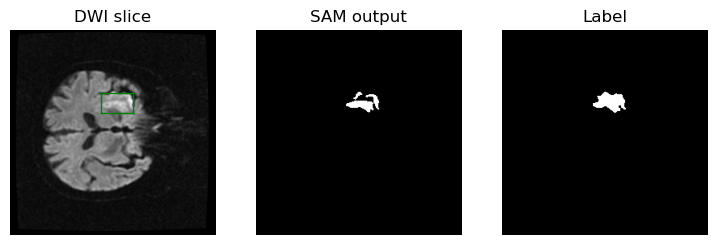

Dice for slice: 0.888


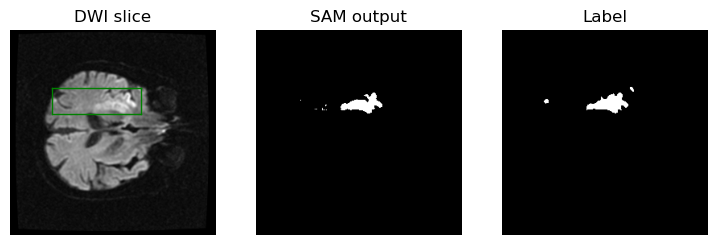

Dice for slice: 0.877


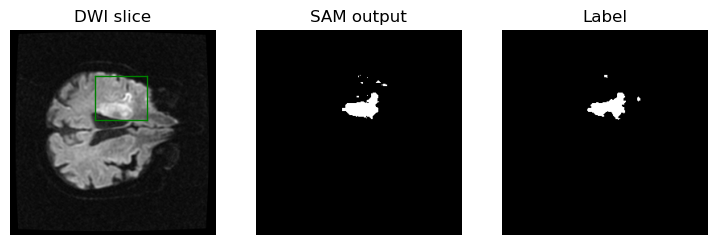

Dice for slice: 0.919


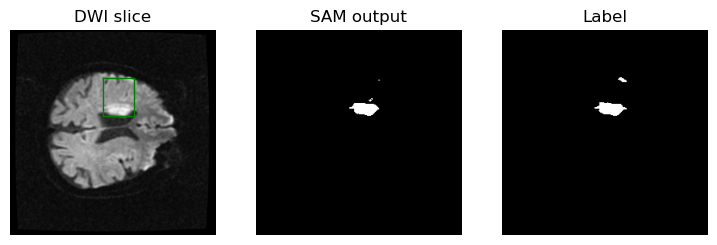

Dice for slice: 0.625


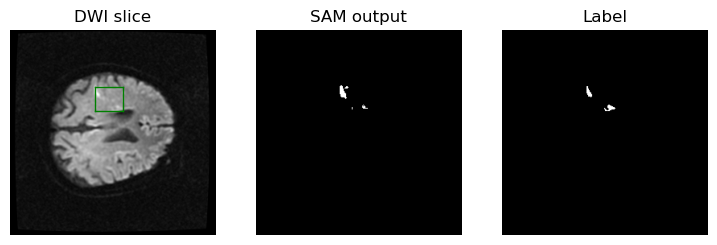

Dice for slice: 0.774


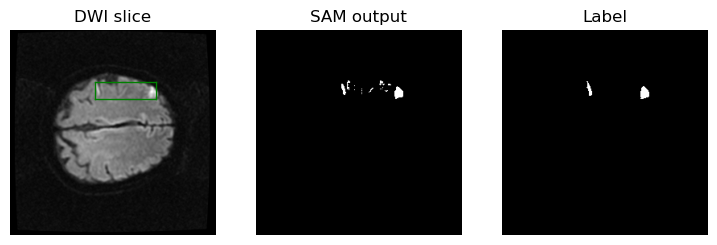

Dice for slice: 0.831


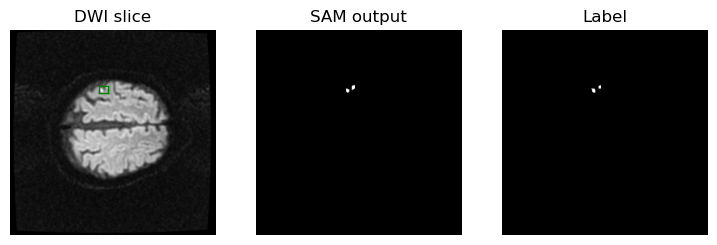

Mean dice for subject: 0.77
_____________________________
Volume: 2 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 1/1 [00:10<00:00, 10.21s/it]

Dice for slice: 0.95


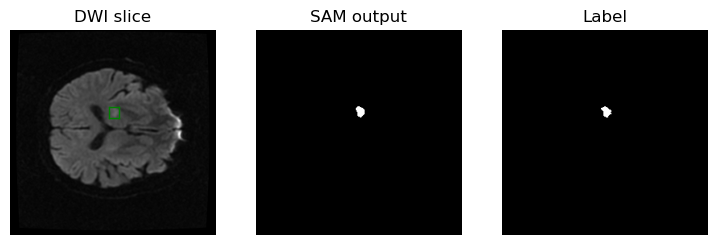

Mean dice for subject: 0.95
_____________________________
Volume: 3 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 10/10 [01:47<00:00, 10.74s/it]

Dice for slice: 0.782


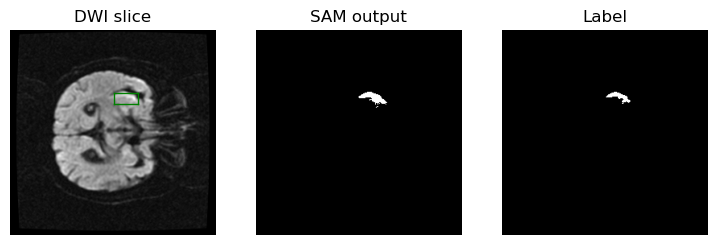

Dice for slice: 0.883


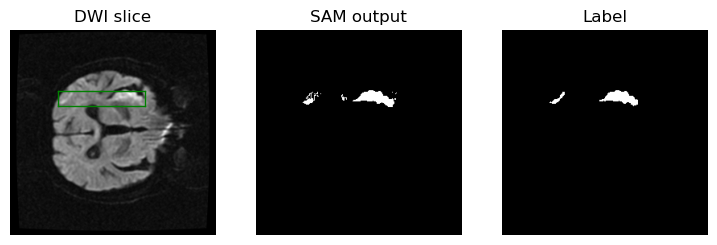

Dice for slice: 0.758


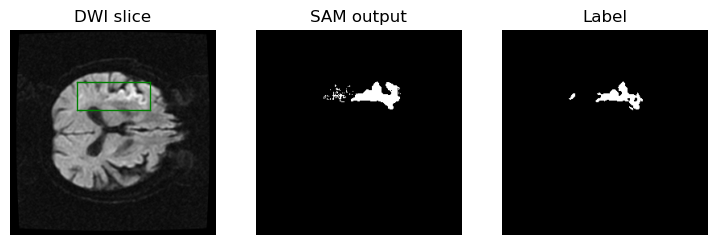

Dice for slice: 0.807


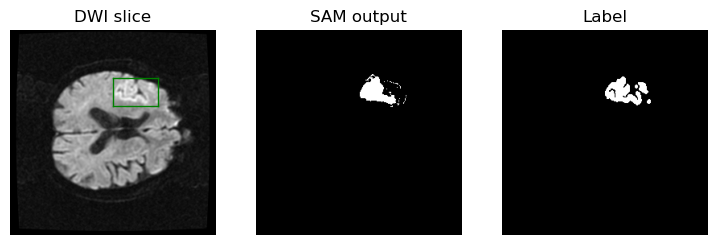

Dice for slice: 0.607


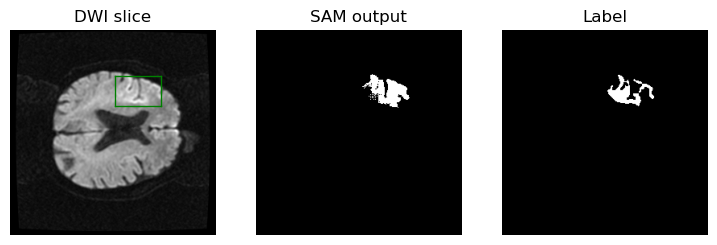

Dice for slice: 0.061


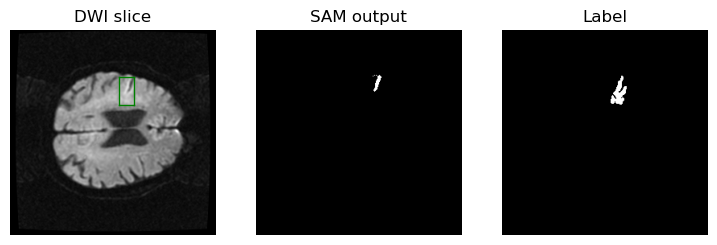

Dice for slice: 0.27


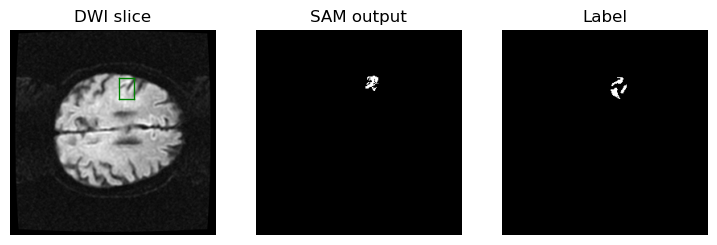

Dice for slice: 0.565


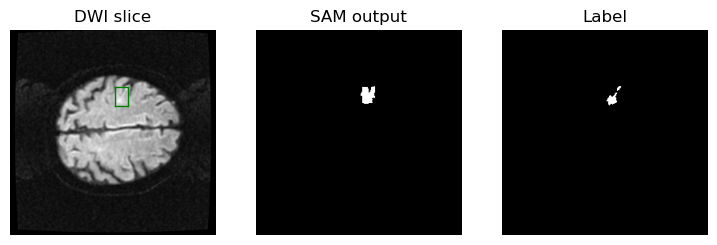

Dice for slice: 0.718


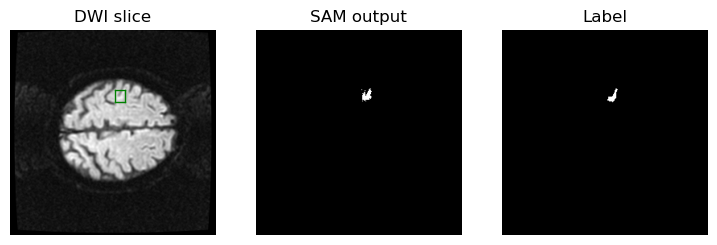

Dice for slice: 0.737


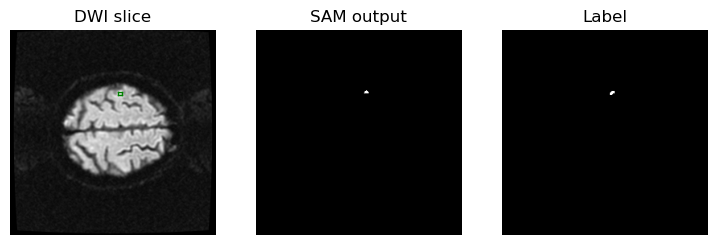

Mean dice for subject: 0.619
_____________________________
Volume: 4 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 10/10 [01:46<00:00, 10.65s/it]

Dice for slice: 0.867


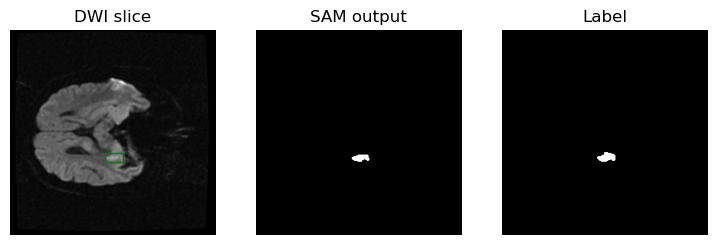

Dice for slice: 0.846


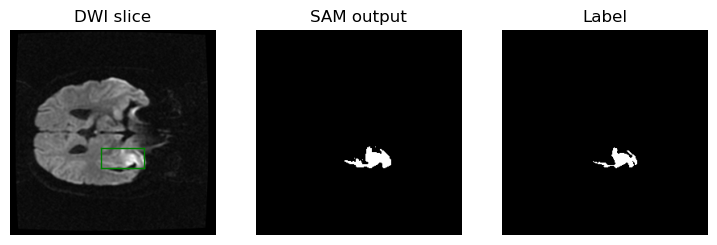

Dice for slice: 0.917


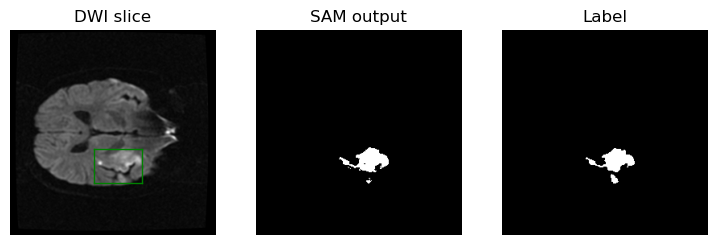

Dice for slice: 0.876


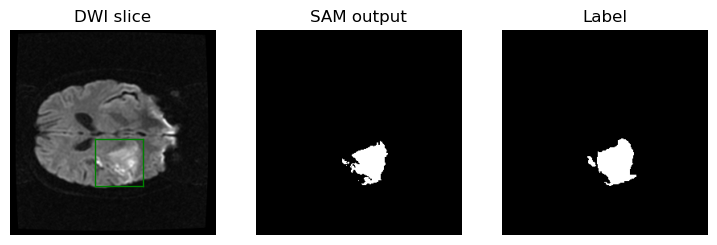

Dice for slice: 0.872


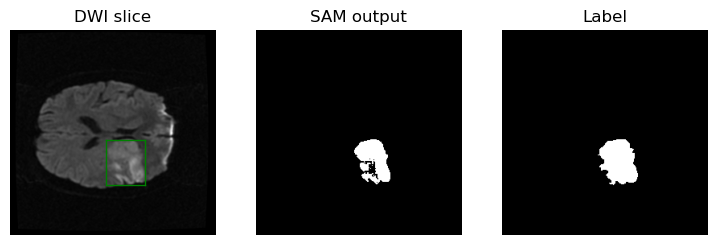

Dice for slice: 0.86


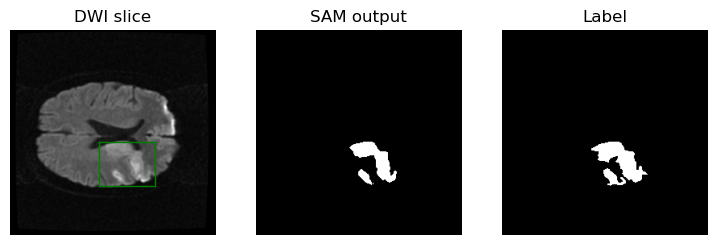

Dice for slice: 0.797


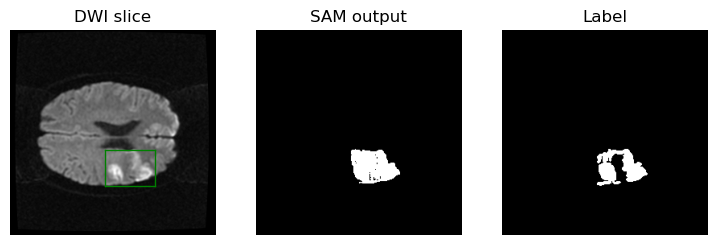

Dice for slice: 0.765


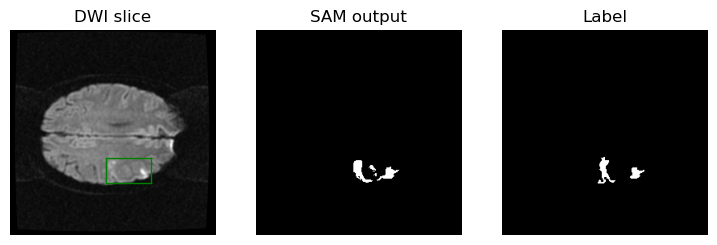

Dice for slice: 0.917


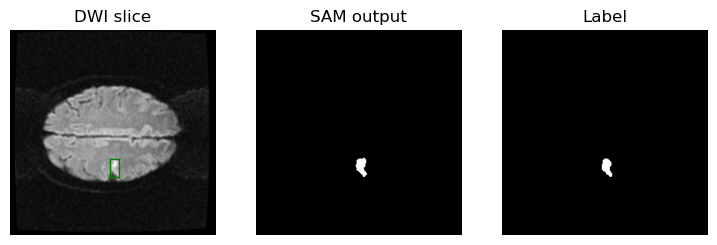

Dice for slice: 0.86


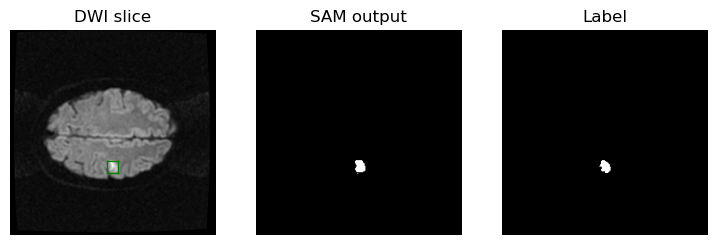

Mean dice for subject: 0.858
_____________________________
Volume: 5 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 4/4 [00:41<00:00, 10.25s/it]

Dice for slice: 0.838


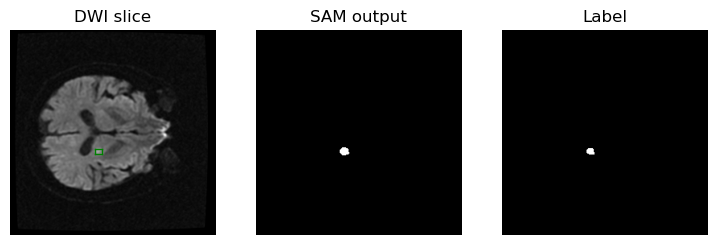

Dice for slice: 0.909


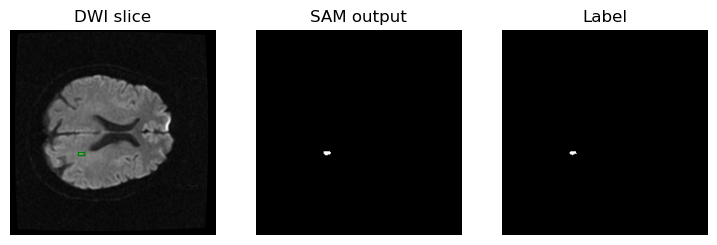

Dice for slice: 0.884


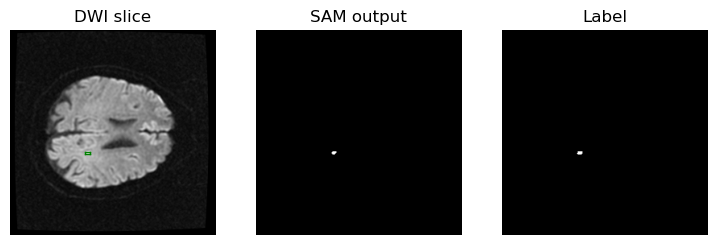

Dice for slice: 0.851


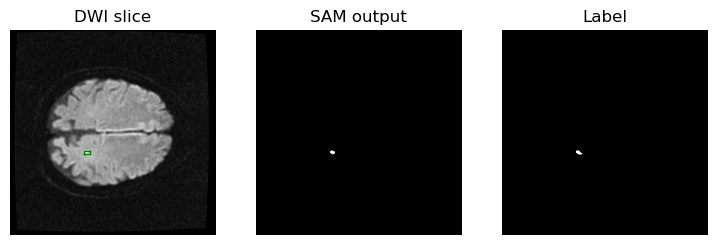

Mean dice for subject: 0.87
_____________________________
Volume: 6 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 7/7 [01:15<00:00, 10.83s/it]

Dice for slice: 0.741


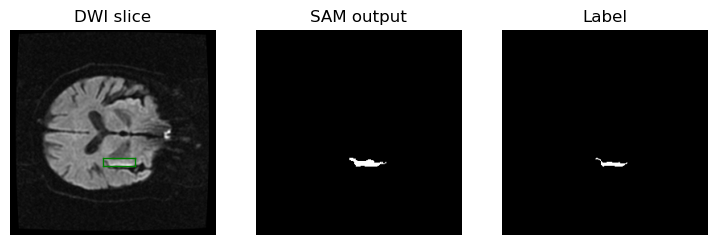

Dice for slice: 0.546


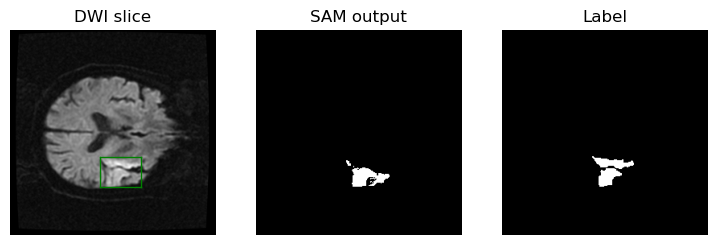

Dice for slice: 0.803


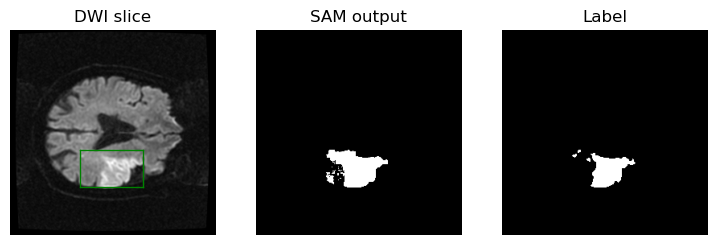

Dice for slice: 0.814


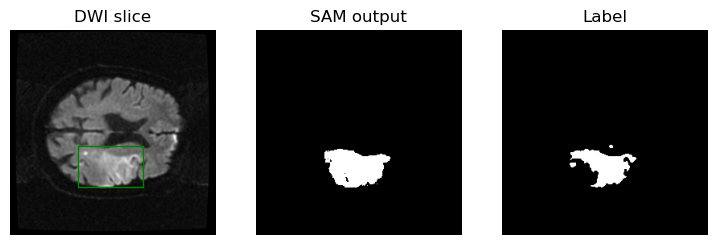

Dice for slice: 0.756


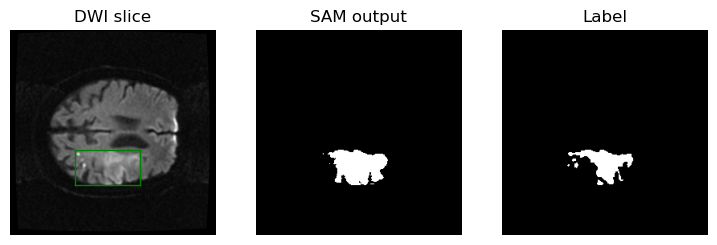

Dice for slice: 0.769


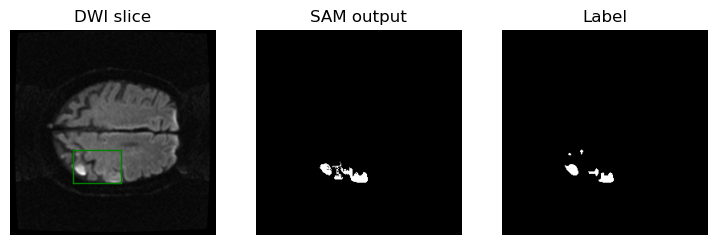

Dice for slice: 0.116


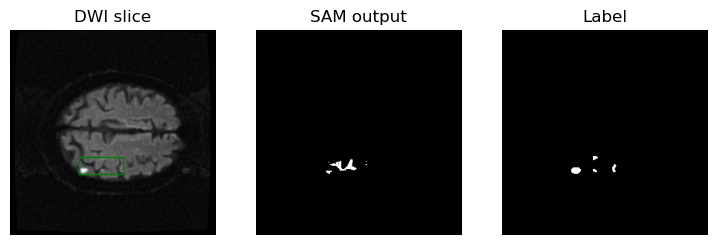

Mean dice for subject: 0.649
_____________________________
Volume: 7 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 6/6 [01:06<00:00, 11.01s/it]

Dice for slice: 0.95


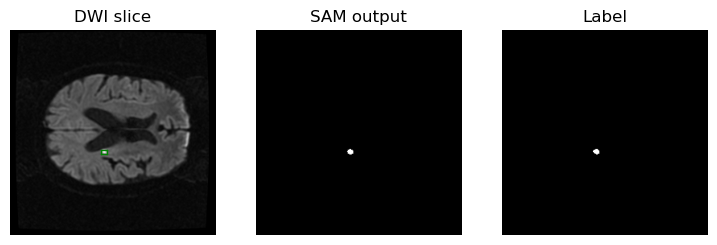

Dice for slice: 0.903


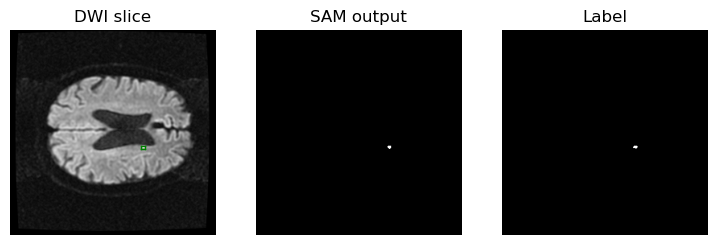

Dice for slice: 0.9


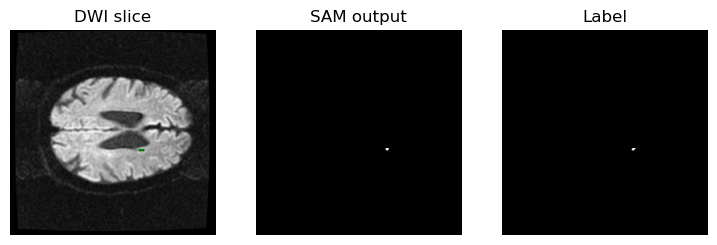

Dice for slice: 0.815


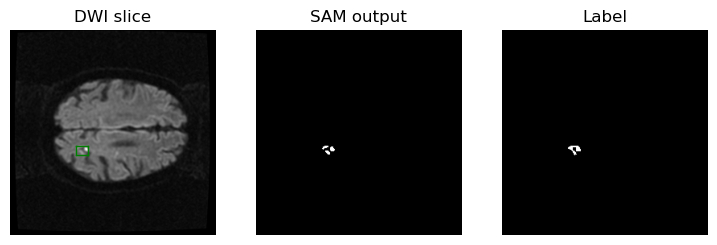

Dice for slice: 0.494


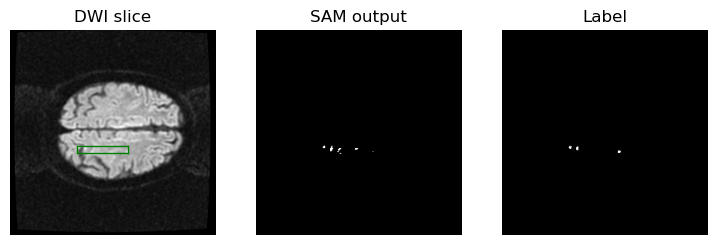

Dice for slice: 0.911


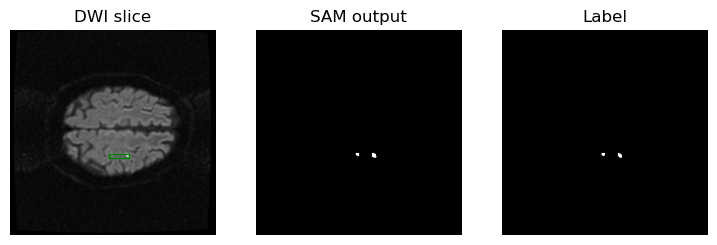

Mean dice for subject: 0.829
_____________________________
Volume: 8 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 10/10 [01:51<00:00, 11.18s/it]

Dice for slice: 0.562


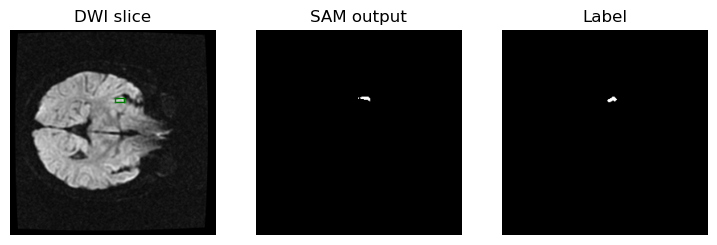

Dice for slice: 0.91


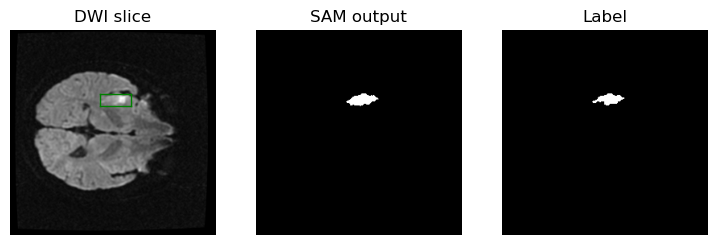

Dice for slice: 0.894


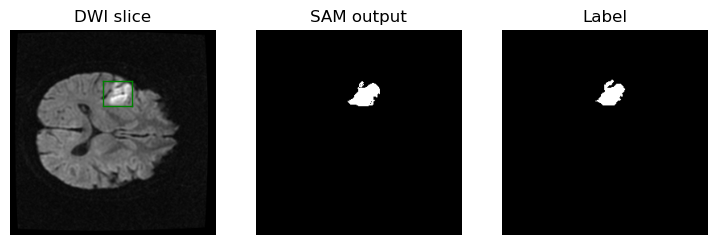

Dice for slice: 0.973


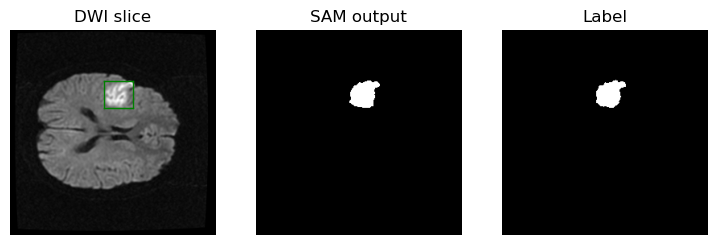

Dice for slice: 0.944


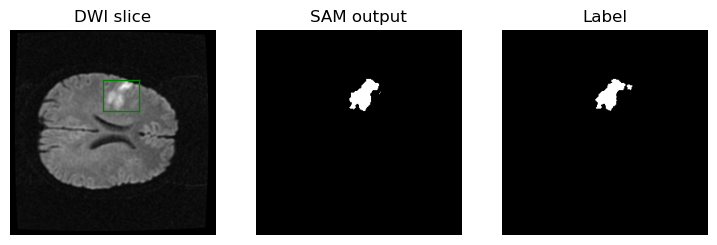

Dice for slice: 0.557


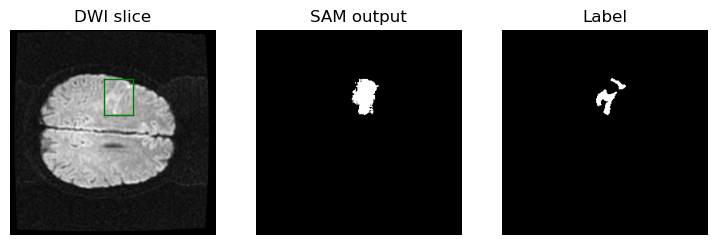

Dice for slice: 0.795


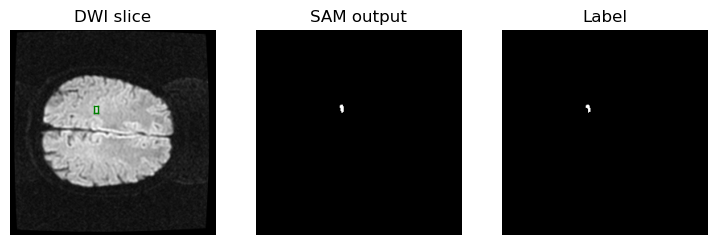

Dice for slice: 0.667


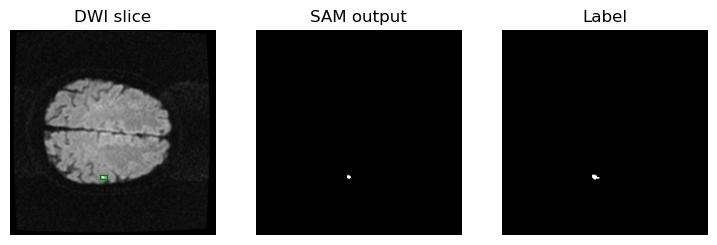

Dice for slice: 0.88


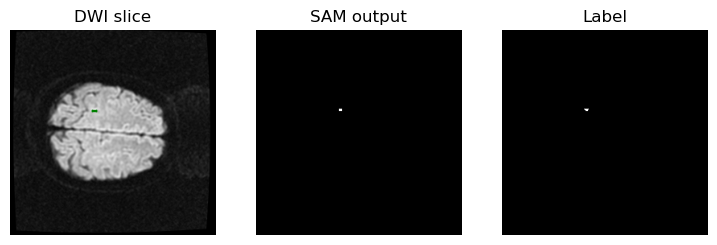

Dice for slice: 0.852


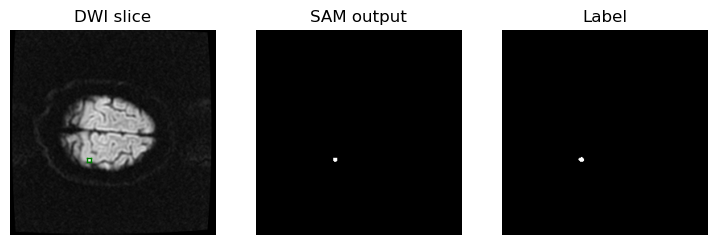

Mean dice for subject: 0.803
_____________________________
______________________________________________
Mean dice for each subject: [0.7697790100686633, 0.9497716894977168, 0.6186858532157413, 0.8578427892476889, 0.8703439172776753, 0.6491802390816113, 0.8289018882042032, 0.8032386007430601]

Mean dice for all subjects: 0.7934679984170451


In [3]:
#Test loop
print('General Sam model',channels,'version')
batchSize = 1
type = 'test'
Avg_Dice_subjects = []
Dice_for_subjects = []
for i in range(0,len(data)):
      print(f'Volume: {i+1} of {len(data)}')
      outputs = []
      
      # Get paths to scans and masks for each subject in the datasplit
      DWI_path, ADC_path, b0_path, label_path = data[i]

      # Load data for DAGMNET:
      dataset = getVolume(DWI_path, ADC_path, b0_path, label_path, channels)

      # Get the bounding_box to prompt SAM:
      label_vol = nib.load(label_path).get_fdata()
      prompt = get_bounding_box(label_vol, False)

      # Load data for SAM:
      val_dataset = SAMDataset(dataset = dataset, processor = processor, type = type, prompt = prompt, channels = channels)
      val_dataloader = DataLoader(val_dataset, batch_size = batchSize, shuffle = False, drop_last = False)

      for batch in tqdm(val_dataloader):
            # forward pass
            with torch.cuda.amp.autocast():
                  output = model(pixel_values=batch["pixel_values"].to(device), input_boxes=batch["input_boxes"].to(device), multimask_output=False)
            torch.cuda.empty_cache()
            output = output.pred_masks.squeeze(1)
            outputs.append(np.asarray(torch.squeeze(output[0,:,:,:]).cpu().detach()))

      # Dice and Plot
      dice_vol = plotAndDice(label_vol, DWI_path, prompt, outputs)
      Dice_for_subjects.append(dice_vol)
      Avg_Dice_subjects.append(mean(dice_vol))     
      print('_____________________________')
print('______________________________________________')
print('Mean dice for each subject:', Avg_Dice_subjects)
print('')
print('Mean dice for all subjects:', mean(Avg_Dice_subjects))

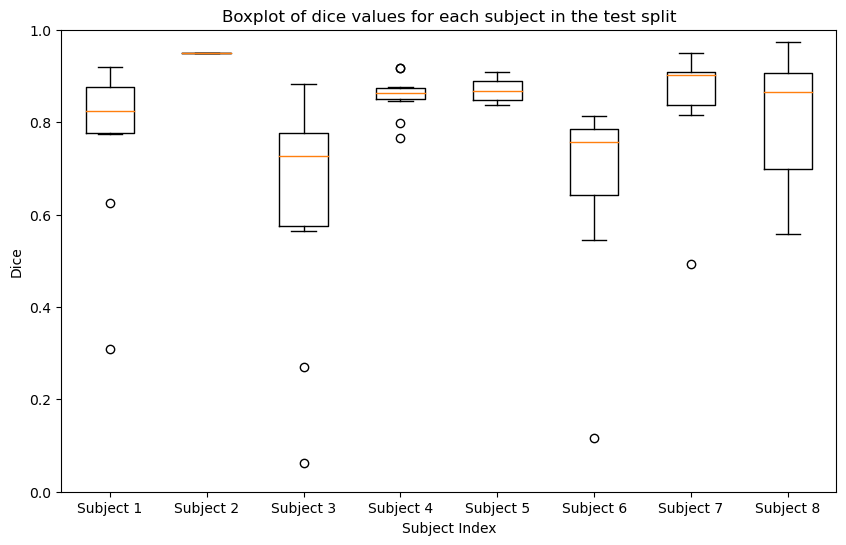

In [4]:
# Example data: a list of lists
data = Dice_for_subjects

# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

# Create the boxplot
plt.boxplot(data)

# Adding titles and labels
plt.title('Boxplot of dice values for each subject in the test split')
plt.xlabel('Subject Index')
plt.ylabel('Dice')

# Customize x-axis labels if needed
plt.xticks(range(1, len(data) + 1), ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8'])

# Set y-axis limits
plt.ylim(0, 1)

# Show the plot
plt.show()